 ## Deepfake Manipulation Detection

#### Imports

In [59]:
import cv2
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, BatchNormalization,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

ModuleNotFoundError: No module named 'torch'

#### Video paths

In [3]:
# ff_originals = './data/face_forensics++/originals'
# ff_deepfakes = './data/face_forensics++/deepfakes'
# ff_test_originals = './data/face_forensics++/test_originals'
# ff_test_deepfakes = './data/face_forensics++/test_deepfakes'
# celeb_test_originals = './data/celeb_df_v2/test_originals'
# celeb_test_deepfakes = './data/celeb_df_v2/test_deepfakes'
# celeb_originals = './data/celeb_df_v2/originals'
# celeb_deepfakes = './data/celeb_df_v2/deepfakes'

originals = './test_data/originals'
deepfakes = './test_data/deepfakes'

#### FaceLandmarker Options

In [4]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options = BaseOptions(model_asset_path='./models/face_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    output_face_blendshapes=True,
    output_facial_transformation_matrixes=True,
    num_faces=1
)

#### Process videos to facial matrices and blendshapes

In [56]:
def process_video(video_path, options, fps):
    cap = cv2.VideoCapture(video_path)

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)

    transformation_matrices = []
    blendshapes = []
    timestamps = []
    frame_count = 0

    with FaceLandmarker.create_from_options(options) as face_landmarker:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            if frame_count % frame_interval == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
                frame_timestamp = int(cap.get(cv2.CAP_PROP_POS_MSEC))

                face_landmarker_result = face_landmarker.detect_for_video(mp_image, frame_timestamp)

                if face_landmarker_result.face_blendshapes:
                    # collect blendshapes
                    for blendshape in face_landmarker_result.face_blendshapes:
                        scores = [Category.score for Category in blendshape]
                        blendshapes.append(scores)
                        timestamps.append(frame_timestamp)
                    # collect facial matrices
                    for matrix in face_landmarker_result.facial_transformation_matrixes:
                        transformation_matrices.append(matrix.flatten())
                
                if len(blendshapes) > 24: # get the first 10 frames only
                    break

            frame_count += 1  # Increment frame counter

        cap.release()

    return np.array(blendshapes), np.array(transformation_matrices), np.array(timestamps)

In [8]:
def process_video_facial_matrices(video_path, label, options, fps):
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps) 

    transformation_matrices = []
    timestamps = []
    frame_count = 0

    with FaceLandmarker.create_from_options(options) as face_landmarker:

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            if frame_count % frame_interval == 0:

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

                frame_timestamp = int(cap.get(cv2.CAP_PROP_POS_MSEC))

                face_landmarker_result = face_landmarker.detect_for_video(mp_image, frame_timestamp)

                if face_landmarker_result.facial_transformation_matrixes:
                    for matrix in face_landmarker_result.facial_transformation_matrixes:
                        transformation_matrices.append(matrix.flatten())
                        timestamps.append(frame_timestamp)

                if len(transformation_matrices) > 9:
                    break

            frame_count += 1  # Increment frame counter

        cap.release()

    return np.array(transformation_matrices), np.array(timestamps), label

In [6]:
def process_video_blendshapes(video_path, label, options, fps):
    cap = cv2.VideoCapture(video_path)

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)

    blendshapes = []
    timestamps = []
    frame_count = 0

    with mp.tasks.vision.FaceLandmarker.create_from_options(options) as face_landmarker:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            if frame_count % frame_interval == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
                frame_timestamp = int(cap.get(cv2.CAP_PROP_POS_MSEC))

                face_landmarker_result = face_landmarker.detect_for_video(mp_image, frame_timestamp)

                if face_landmarker_result.face_blendshapes:
                    for blendshape in face_landmarker_result.face_blendshapes:
                        scores = [Category.score for Category in blendshape]
                        blendshapes.append(scores)
                        timestamps.append(frame_timestamp)

                if len(blendshapes) > 9:
                    break

            frame_count += 1  # Increment frame counter

        cap.release()

    return np.array(blendshapes), np.array(timestamps), label

#### Load Data Function

In [57]:
def load_data(originals, deepfakes, options, fps):
    X_matrices = []
    X_blendshapes = []
    y = []


    for video_path in os.listdir(originals):
        blendshapes, matrices, timestamps = process_video(video_path=os.path.join(originals, video_path), options=options, fps=fps)
        if matrices.size == 0:
            continue

        timestamps = timestamps.reshape(-1,1)      
        # collect matrices and timestamps
        combined_matrices = np.hstack((matrices, timestamps/1000.0))

        # collect blendshapes and timestamps
        combined_blendshapes = np.hstack((blendshapes, timestamps/1000.0))

        X_matrices.append(combined_matrices)
        X_blendshapes.append(combined_blendshapes)
        y.append(0) # label
    
    print("ORIGINALS DONEEEEE")

    for video_path in os.listdir(deepfakes):

        blendshapes, matrices, timestamps = process_video(video_path= os.path.join(deepfakes, video_path), options=options, fps=fps)
        if matrices.size == 0:
            continue 

        timestamps = timestamps.reshape(-1,1)      
        # collect matrices and timestamps
        combined_matrices = np.hstack((matrices, timestamps/1000.0))
        # collect blendshapes and timestamps
        combined_blendshapes = np.hstack((blendshapes, timestamps/1000.0))
        X_matrices.append(combined_matrices)
        X_blendshapes.append(combined_blendshapes)
        y.append(1) # label
    
    # Pad X to ensure all have the same length
    X_blendshapes_padded = pad_sequences(X_blendshapes, padding='post', dtype='float32')
    X_matrices_padded = pad_sequences(X_matrices, padding='post', dtype='float32')



    # Convert lists to numpy arrays
    # X = np.array(X)
    # y = np.array(y).reshape(-1, 1)  # Ensure y is in the correct shape (number_of_samples, 1)

    return np.array(X_blendshapes_padded), np.array(X_matrices_padded), np.array(y)



#### Data Loaders

In [ ]:
X_ff_blendshapes_test, X_ff_matrices_test, y = load_data(ff_test_originals, ff_test_deepfakes, options, fps=15)

In [23]:
print(X_ff_blendshapes_test.shape, X_ff_matrices_test.shape, y.shape)

(117, 10, 53) (117, 10, 17) (117, 1)


In [ ]:
# Celeb Test
X_celeb_test, y_celeb_test = load_data(celeb_originals, celeb_test_deepfakes, options, process_video_blendshapes)

In [ ]:
X_celeb, y_celeb = load_data(celeb_originals, celeb_deepfakes, options, process_video_blendshapes)

In [ ]:
X_ff, y_ff = load_data(ff_originals, ff_deepfakes, options, process_video_blendshapes)

In [58]:
X_blendshapes, X_matrices, y = load_data(originals, deepfakes, options, 15)

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


ORIGINALS DONEEEEE


In [17]:
# splitting 
X_train_blendshapes, X_test_blendshapes, y_train_blendshapes, y_test_blendshapes = train_test_split(X_blendshapes, y, test_size=0.3)

In [18]:
print(f"Shape of X_train: {X_train_blendshapes.shape}")
print(f"Shape of y_train: {y_train_blendshapes.shape}")
print(f"Shape of X_test: {X_test_blendshapes.shape}")
print(f"Shape of y_test: {y_test_blendshapes.shape}")


Shape of X_train: (147, 10, 53)
Shape of y_train: (147,)
Shape of X_test: (63, 10, 53)
Shape of y_test: (63,)


In [209]:
# # Binarize the labels
# lb = LabelBinarizer()
# y_train_ff = lb.fit_transform(y_train_ff)
# y_test_ff = lb.transform(y_test_ff)

In [20]:
# Define the LSTM model
model = Sequential()
# model.add(Masking(mask_value=0.0, input_shape=(Xnp.shape[1], Xnp.shape[2])))
model.add(LSTM(64, return_sequences=False), input_shape=(X_train_blendshapes.shape[1], X_train_blendshapes.shape[2]))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

TypeError: Sequential.add() got an unexpected keyword argument 'input_shape'

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

In [21]:
# Define the enhanced LSTM model
model2 = Sequential()

# Add LSTM layers with more units and dropout for regularization
model2.add(LSTM(128, return_sequences=True, input_shape=(X_train_blendshapes.shape[1], X_train_blendshapes.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))

# Add a Batch Normalization layer
model2.add(BatchNormalization())

# Add Dense layers with Dropout
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │        93,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,121 (582.50 KB)

 Trainable params: 148,993 (582.00 KB)

 Non-trainable params: 128 (512.00 B)

In [22]:
history = model2.fit(X_train_blendshapes, y_train_blendshapes, epochs=20, batch_size=32, validation_split=0.3, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.4956 - loss: 0.8228 - val_accuracy: 0.5111 - val_loss: 0.6954
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6015 - loss: 0.7227 - val_accuracy: 0.5111 - val_loss: 0.6960
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5209 - loss: 0.7192 - val_accuracy: 0.5111 - val_loss: 0.6961
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5730 - loss: 0.7001 - val_accuracy: 0.5111 - val_loss: 0.6963
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6301 - loss: 0.6403 - val_accuracy: 0.4667 - val_loss: 0.6966
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6469 - loss: 0.6473 - val_accuracy: 0.4889 - val_loss: 0.6959
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5960 - loss: 0.6577 - val_accuracy: 0.4889 - val_loss: 0.6950
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6385 - loss: 0.5799 - val_accuracy: 0.5333 - val_loss: 0.6936

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test_blendshapes, y_test_blendshapes, verbose=1)
print(f'Test Accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5893 - loss: 0.6800 
Test Accuracy: 0.5714285969734192


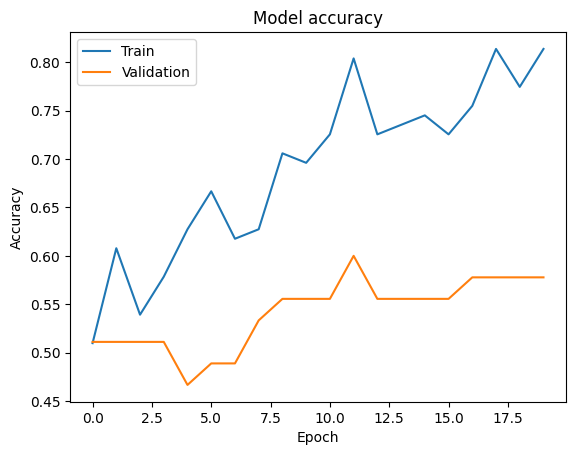

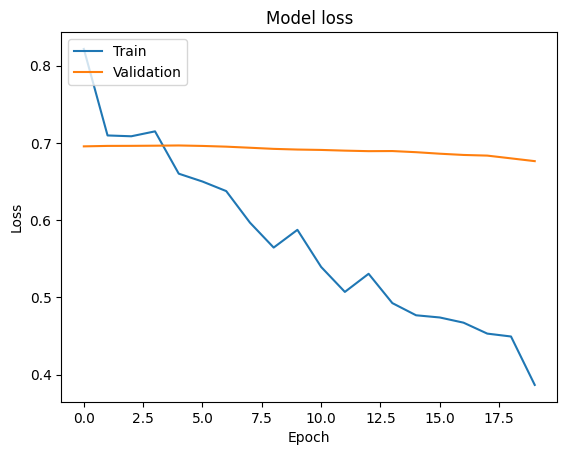

In [25]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### More Complex LSTM

In [27]:

# Define the enhanced LSTM model
model2 = Sequential()

# Add Bidirectional LSTM layers with more units and dropout for regularization
model2.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_blendshapes.shape[1], X_train_blendshapes.shape[2])))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(32, return_sequences=False)))
model2.add(Dropout(0.3))

# Add a Batch Normalization layer
model2.add(BatchNormalization())

# Add Dense layers with Dropout
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │       186,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,881 (1.57 MB)

 Trainable params: 410,753 (1.57 MB)

 Non-trainable params: 128 (512.00 B)

In [28]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [30]:
# Train the model with validation split
history2 = model2.fit(X_train_blendshapes, y_train_blendshapes, epochs=100, batch_size=32, validation_split=0.4, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.5813 - loss: 0.6635 - val_accuracy: 0.4407 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5036 - loss: 0.7089 - val_accuracy: 0.4407 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5668 - loss: 0.6817 - val_accuracy: 0.4407 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5579 - loss: 0.6903 - val_accuracy: 0.4407 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5036 - loss: 0.6840 - val_accuracy: 0.4407 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5192 - loss: 0.7058 - val_accuracy: 0.4407 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6847 - loss: 0.6008 - val_accuracy:

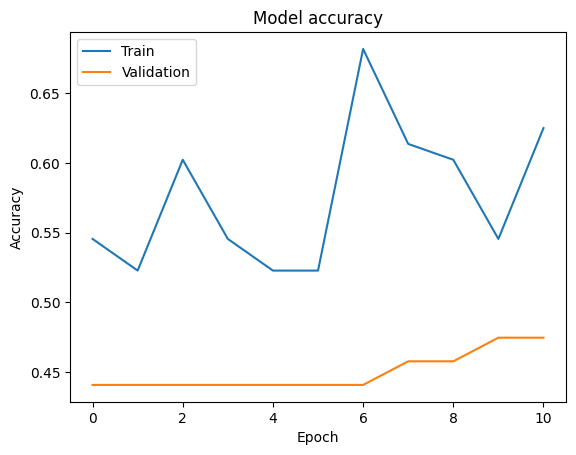

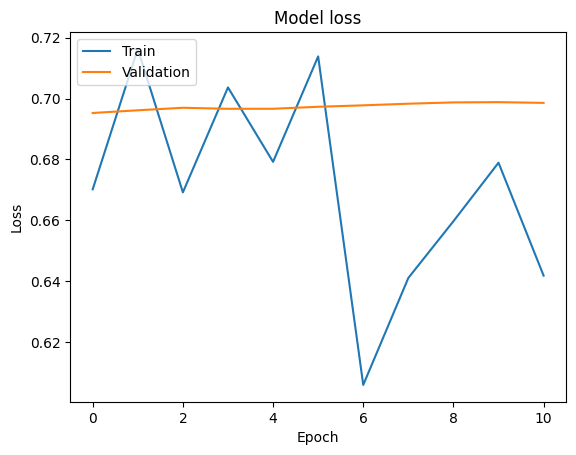

In [31]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test_blendshapes, y_test_blendshapes, verbose=1)
print(f'Test Accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4529 - loss: 0.6946 
Test Accuracy: 0.4761904776096344


#### Model 3

In [35]:
# Define a more complex LSTM model
model3 = Sequential()

# Add multiple Bidirectional LSTM layers with more units and dropout for regularization
model3.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.3), input_shape=(X_train_blendshapes.shape[1], X_train_blendshapes.shape[2])))
model3.add(Dropout(0.4))
model3.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.3)))
model3.add(Dropout(0.4))
model3.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.3)))
model3.add(Dropout(0.4))
model3.add(Bidirectional(LSTM(32, return_sequences=False, recurrent_dropout=0.3)))
model3.add(Dropout(0.4))

# Add a Batch Normalization layer
model3.add(BatchNormalization())

# Add multiple Dense layers with more units and Dropout
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model3.summary()



c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 10, 512)        │       634,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 10, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 10, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,993 (5.94 MB)

 Trainable params: 1,556,865 (5.94 MB)

 Non-trainable params: 128 (512.00 B)

In [36]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [38]:

# Train the model with validation split
history3 = model3.fit(X_train_blendshapes, y_train_blendshapes, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - accuracy: 0.4519 - loss: 0.8167 - val_accuracy: 0.5667 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5504 - loss: 0.7084 - val_accuracy: 0.6000 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4864 - loss: 0.7450 - val_accuracy: 0.5333 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5428 - loss: 0.6800 - val_accuracy: 0.5333 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6366 - loss: 0.6662 - val_accuracy: 0.5333 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5014 - loss: 0.7111 - val_accuracy: 0.5333 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6186 - loss: 0.6550 - val_accuracy

In [41]:
# Evaluate the model on the test set
test_loss, test_acc = model3.evaluate(X_test_blendshapes, y_test_blendshapes, verbose=1)
print(f'Test Accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5261 - loss: 0.6920
Test Accuracy: 0.5079365372657776


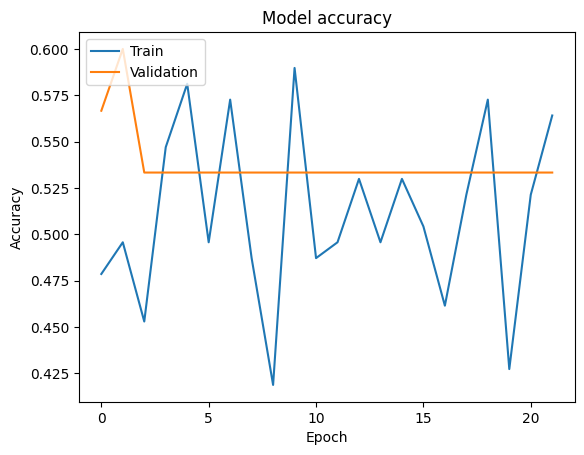

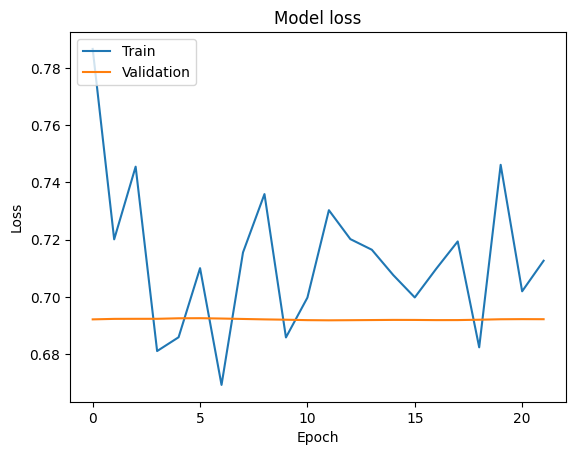

In [42]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### CNN model

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense, BatchNormalization

# Define a CNN model for sequence data
model_cnn = Sequential()

# Add 1D convolutional layers
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_blendshapes.shape[1], X_train_blendshapes.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model_cnn.add(GlobalAveragePooling1D())
model_cnn.add(Dropout(0.3))

# Add Dense layers
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_cnn.summary()


c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 128)`, `kernel shape=(3, 128, 256)`, `dilation_rate=[1]`.

In [ ]:

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with validation split
history = model_cnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

#### Transformer Model

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a Transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Define the Transformer model
input_shape = (X_train_blendshapes.shape[1], X_train_blendshapes.shape[2])
inputs = Input(shape=input_shape)

x = transformer_block(inputs, head_size=256, num_heads=4, ff_dim=128, dropout=0.3)
x = transformer_block(x, head_size=256, num_heads=4, ff_dim=128, dropout=0.3)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_transformer = Model(inputs, outputs)

# Compile the model
model_transformer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_transformer.summary()



Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 53)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 53)    │    220,213 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 10, 53)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 53)    │        106 │ dropout_21[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 53)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10, 128)   │      6,912 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 10, 128)   │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10, 53)    │      6,837 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 53)    │        106 │ dense_13[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 53)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 53)    │    220,213 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 10, 53)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 53)    │        106 │ dropout_24[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 53)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10, 128)   │      6,912 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 10, 128)   │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10, 53)    │      6,837 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 53)    │        106 │ dense_15[0][0]    │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 483,581 (1.84 MB)

 Trainable params: 483,581 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with validation split
history_trans = model_transformer.fit(X_train_blendshapes, y_train_blendshapes, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.5370 - loss: 0.9464 - val_accuracy: 0.4222 - val_loss: 0.8210 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5206 - loss: 0.8059 - val_accuracy: 0.4444 - val_loss: 0.9210 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4559 - loss: 0.9866 - val_accuracy: 0.5556 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5268 - loss: 0.8446 - val_accuracy: 0.4222 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5602 - loss: 0.7236 - val_accuracy: 0.4667 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5196 - loss: 0.7404 - val_accuracy: 0.4444 - val_loss: 0.7344 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5319 - loss: 0.7191 - val_accuracy:

In [49]:
# Evaluate the model on the test set
test_loss, test_acc = model_transformer.evaluate(X_test_blendshapes, y_test_blendshapes, verbose=1)
print(f'Test Accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5051 - loss: 0.7020
Test Accuracy: 0.4920634925365448


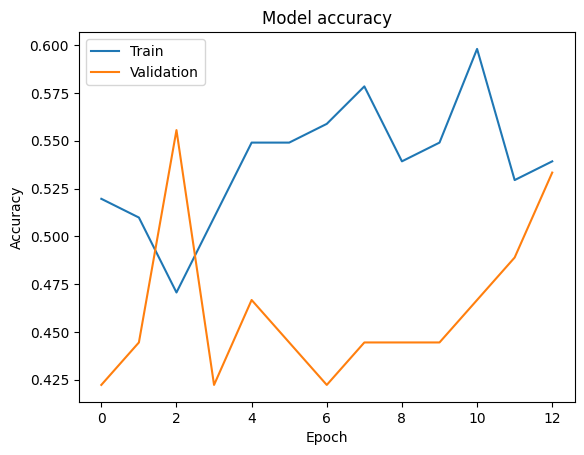

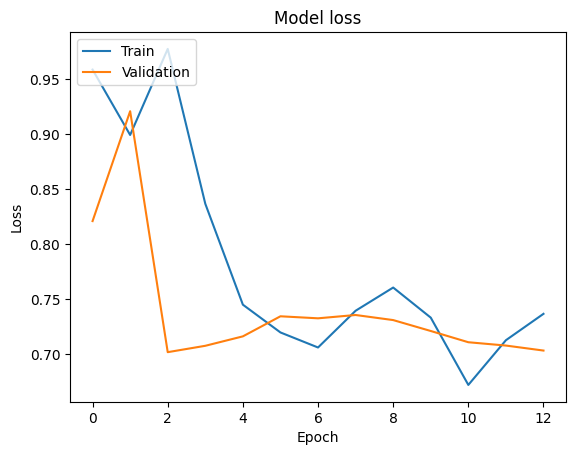

In [50]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_trans.history['accuracy'])
plt.plot(history_trans.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_trans.history['loss'])
plt.plot(history_trans.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Hybrid Model

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization

# Define a hybrid CNN + LSTM model
model_hybrid = Sequential()

# Add 1D convolutional layers
model_hybrid.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_blendshapes.shape[1], X_train_blendshapes.shape[2])))
model_hybrid.add(MaxPooling1D(pool_size=2))
model_hybrid.add(Dropout(0.3))
model_hybrid.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_hybrid.add(MaxPooling1D(pool_size=2))
model_hybrid.add(Dropout(0.3))

# Add LSTM layers
model_hybrid.add(LSTM(128, return_sequences=True))
model_hybrid.add(Dropout(0.3))
model_hybrid.add(LSTM(64, return_sequences=False))
model_hybrid.add(Dropout(0.3))

# Add Dense layers
model_hybrid.add(BatchNormalization())
model_hybrid.add(Dense(128, activation='relu'))
model_hybrid.add(Dropout(0.4))
model_hybrid.add(Dense(64, activation='relu'))
model_hybrid.add(Dropout(0.4))
model_hybrid.add(Dense(1, activation='sigmoid'))

# Compile the model
model_hybrid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_hybrid.summary()



c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 8, 64)          │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,833 (909.50 KB)

 Trainable params: 232,705 (909.00 KB)

 Non-trainable params: 128 (512.00 B)

In [53]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with validation split
history_hybrid = model_hybrid.fit(X_train_blendshapes, y_train_blendshapes, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.5023 - loss: 0.7058 - val_accuracy: 0.4444 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4854 - loss: 0.6880 - val_accuracy: 0.4444 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4697 - loss: 0.7012 - val_accuracy: 0.4444 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5720 - loss: 0.6836 - val_accuracy: 0.4444 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5159 - loss: 0.6894 - val_accuracy: 0.4444 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5991 - loss: 0.6936 - val_accuracy: 0.4444 - val_loss: 0.6963 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5994 - loss: 0.6731 - val_accuracy:

In [54]:
# Evaluate the model on the test set
test_loss, test_acc = model_hybrid.evaluate(X_test_blendshapes, y_test_blendshapes, verbose=1)
print(f'Test Accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4739 - loss: 0.6934 
Test Accuracy: 0.4920634925365448


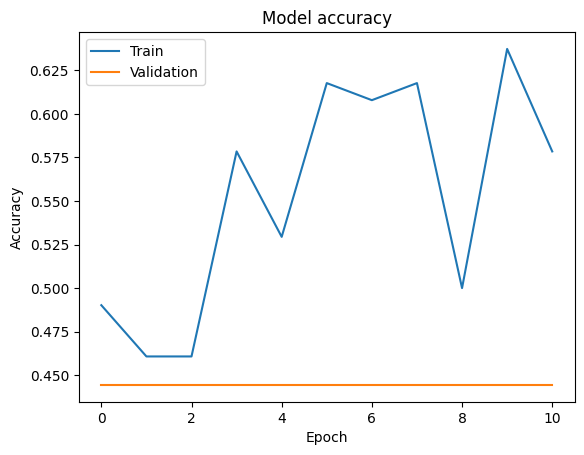

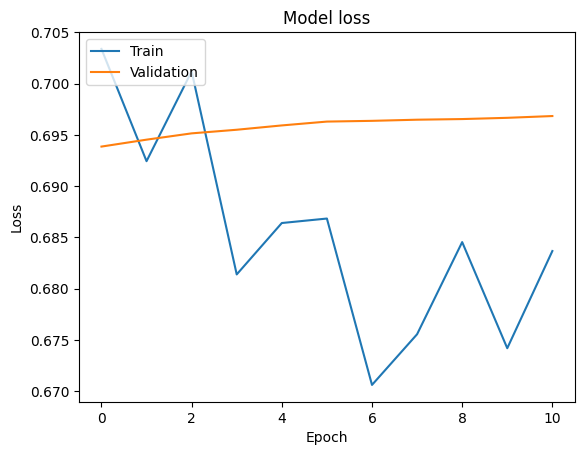

In [55]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_hybrid.history['accuracy'])
plt.plot(history_hybrid.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Graph Convolutional Network (GCN)